# 🎓 **Taller 4.2: Taller de Métodos de clustering basados en particiones**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

#Nombre : Mouaaz Alammarin


# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


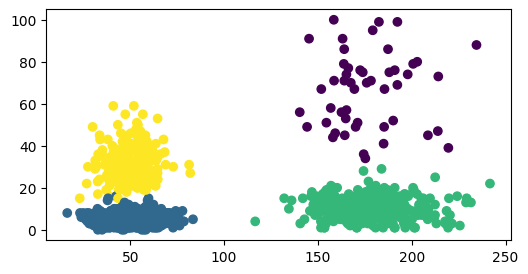

In [3]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **EJ 1:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [70]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[ 34.35806598  16.90801411]
 [ 77.19858348  63.58178481]
 [145.06439459  69.19528433]
 [194.36835382  37.77116138]]


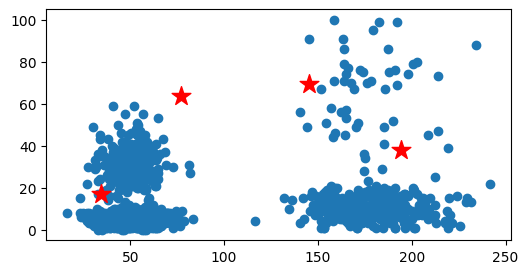

In [91]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [92]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i], cDx)

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

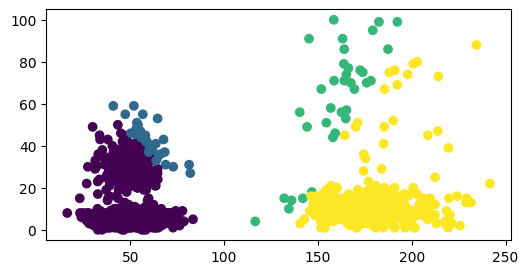

In [93]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [94]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = puntos_cluster_k.mean(axis=0)
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

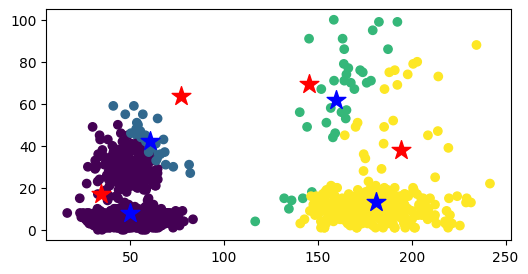

In [95]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [96]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K , Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx,cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx,cDx,Dyp , K) # 1.6 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

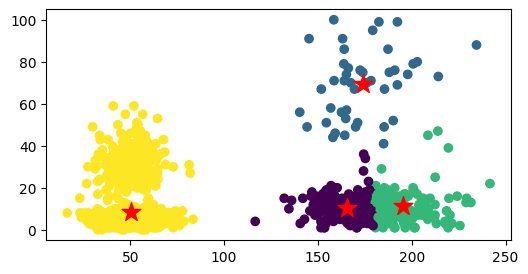

In [97]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: COMPARE SUS RESULTADOS CON SCIKIT-LEARN**

Centros encontrados por...
el método programado:
[[165.36816216  10.48648649]
 [174.06409091  69.38636364]
 [195.22554217  11.13253012]
 [ 50.31548005   8.65710723]]
el método de Sci-kit Learn:
[[ 42.33991304   7.8       ]
 [193.64783505  12.71649485]
 [ 58.35093867   9.52065081]
 [164.63527363  21.76119403]]


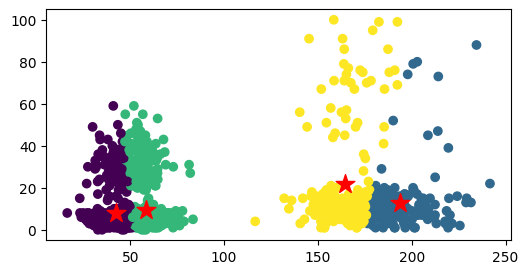

In [98]:
from sklearn.cluster import KMeans

# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=4) # 2.1 Completa el codigo aqui
# Se entrena el modelo
modelo.fit(Dx)# 2.2 Completa el codigo aqui
# Se pedice los clusters
Dyp_sk = modelo.predict(Dx)   # 2.3 Completa el codigo aqui
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print('Centros encontrados por...')
print('el método programado:')
print(cDx)
print('el método de Sci-kit Learn:')
print(cDx_sk)

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')


### 📈 **RESULTADOS:**
**Conteste las siguientes preguntas**

¿Porque difieren los grupos de sklearn con el algoritmo que tu implementaste?

Al analizar los resultados de los clusters obtenidos por ambos métodos, se observa que, aunque los centroides capturan regiones similares del espacio, existen diferencias importantes en su ubicación exacta. Por ejemplo, nuestro método programado encuentra centros alrededor de (50, 8.7), (165, 10.5) y (195, 11.1), mientras que sklearn ubica centros cercanos a (42, 7.8), (58, 9.5) y (193, 12.7), lo que indica que ambos métodos detectan clusters en zonas parecidas. Sin embargo, hay discrepancias más notables en el cluster de mayor dispersión: nuestro algoritmo coloca un centro en (174, 69), mientras que sklearn lo sitúa en (164, 21.8), mostrando que el agrupamiento difiere en cómo se maneja la densidad y dispersión de los puntos. Estas diferencias se deben principalmente a que nuestra implementación usa centroides iniciales aleatorios y un solo ciclo de optimización, mientras que sklearn aplica k-means++ y múltiples reinicios, logrando clusters más equilibrados y representativos de la estructura global del dataset En conjunto, ambos métodos identifican patrones similares, pero sklearn produce una partición más estable y consistente con la densidad real de los datos


# 🎯 **EJ 3: USA LAS METRICAS INTRINSECAS Y EXTRINSECAS PARA DECIDIR QUE TAN BIEN AGRUPADOS ESTAN LOS DATOS**

In [99]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(Dx,Dyp)
print(silhouette_avg)


0.7841629924153366


In [100]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz_score_avg =calinski_harabasz_score(Dx,Dyp)
print(calinski_harabasz_score_avg)


9116.406152168089


In [101]:
def medida_R_cuadrado(X, Xyp, cXs):
    centros_dataset = np.mean(X,axis=0)
    n_clusters = np.sort(np.unique(Xyp)).astype(int) # Cast to int here
    distancia_a_centros_dataset = np.sum((X-centros_dataset)**2)
    distancias_intracluster = np.zeros(n_clusters.size)
    for k in np.arange(n_clusters.size):
        # Use n_clusters[k] as an integer index for cXs
        distancias_intracluster[k] = np.sum((X[Xyp==n_clusters[k], :] - cXs[n_clusters[k], :])**2)
    distancia_intracluster = np.sum(distancias_intracluster)
    # 3.3
    R_Cuadrado = 1 - (distancia_intracluster / distancia_a_centros_dataset)
    return R_Cuadrado

In [102]:
# 3.4 usa R cuadrado
print(medida_R_cuadrado(Dx, Dyp, cDx))

0.9320138649132159


In [103]:
def calcular_inercia(X, labels, centros):
    inercia = 0
    for i, centro in enumerate(centros):
        puntos_cluster = X[labels == i]
        if len(puntos_cluster) > 0:
            distancias = np.sum((puntos_cluster - centro) ** 2, axis=1)
            inercia += np.sum(distancias)
    return inercia

In [104]:
print(calcular_inercia(Dx, Dyp, cDx))

399475.0318196415


### 📈 **RESULTADOS:**
**Interpreta con las medidas intrinsecas que tan bien agrupado estan los clusters**

Los resultados de las medidas intrínsecas muestran que los clusters están bien formados y tienen sentido El valor de R² cercano a 0.93 indica que la mayor parte de la variación de los datos queda explicada por los grupos encontrados, lo que sugiere que el algoritmo logró separar adecuadamente las observaciones Además, la baja inercia intra-cluster refleja que los puntos dentro de cada grupo están bastante cerca entre sí y de su centro, lo que da lugar a clusters compactos en conjunto, estas medidas indican que el agrupamiento es coherente, estable y representativo de la estructura interna de los datos

# 🚀 ¡TALLER FINALIZADO!"